In [264]:
import pandas as pd
import numpy as np
file = pd.read_csv("Hodge.K3")

In [265]:
#Parsing the data 
import re

with open("Hodge.K3", "r") as f: 
    lines = [line.strip() for line in f if line.strip()]
# Keep only lines that are transverse spanning 'TS', and transverse non-spanning 'Tn' :
ts_tn_lines = [line for line in lines if re.search(r'\bT[Sn]\b', line)]

rows = []
labels=[]

with open("Hodge_TS_Tn.txt", "w") as f:
    f.write("\n".join(ts_tn_lines))

for line in ts_tn_lines:
    try:
        # Extract the 5 weights and the degree before "=d"
        weights = [int(x) for x in line.split('=')[0].split()[:5]]
        degree = int(line.split('=')[0].split()[5])

        # Extract Hodge numbers h11, h21
        h_match = re.search(r'H:(\d+)\s+(\d+)', line)
        h11, h21 = map(int, h_match.groups()) if h_match else (None, None)

        # Extract M: points, vertices
        m_match = re.search(r'M:(\d+)\s+(\d+)', line)
        M_points, M_vertices = map(int, m_match.groups()) if m_match else (None, None)

        # Extract N: points, vertices
        n_match = re.search(r'N:(\d+)\s+(\d+)', line)
        N_points, N_vertices = map(int, n_match.groups()) if n_match else (None, None)

        # Extract P and F values
        p_match = re.search(r'P:(-?\d+)', line)

        f_match = re.search(r'F:(-?\d+)', line)
        P = int(p_match.group(1)) if p_match else None
        F = int(f_match.group(1)) if f_match else None

        # Euler number χ = 2*(h11 - h21)
        chi = 2 * (h11 - h21) if (h11 is not None and h21 is not None) else None

        rows.append({
            'w1': weights[0], 'w2': weights[1], 'w3': weights[2],
            'w4': weights[3], 'w5': weights[4], 'degree': degree,
            'M_points': M_points, 'M_vertices': M_vertices,
            'N_points': N_points, 'N_vertices': N_vertices,'F': F,'P': P })
        labels.append({'h11': h11,'h21': h21,'chi': chi})
    except Exception as e:
        print("Error parsing line:", line)
        

file = pd.DataFrame(rows)
file2 = pd.DataFrame(labels)

In [266]:
#Feature engineering

def add_features(file):
    file["prod_w"] = file[[f"w{i}" for i in range(1,6)]].prod(axis=1)
    file["max_w"] = file[[f"w{i}" for i in range(1,6)]].max(axis=1)
    file["min_w"] = file[[f"w{i}" for i in range(1,6)]].min(axis=1)
    file["weight_std"] = file[[f"w{i}" for i in range(1,6)]].std(axis=1)
    return file

file = add_features(file)
print(file.head())


   w1  w2  w3  w4  w5  degree  M_points  M_vertices  N_points  N_vertices  F  \
0   1   1   1   1   1       5       126           5         6           5  0   
1   1   1   1   1   2       6       130           5         6           5  0   
2   1   1   1   1   3       7       159           8         7           6  0   
3   1   1   1   2   2       7       120           9         7           6  0   
4   1   1   1   1   4       8       201           5         7           5  0   

     P  prod_w  max_w  min_w  weight_std  
0  0.0       1      1      1    0.000000  
1  0.0       2      2      1    0.447214  
2  0.0       3      3      1    0.894427  
3  0.0       4      2      1    0.547723  
4  0.0       4      4      1    1.341641  


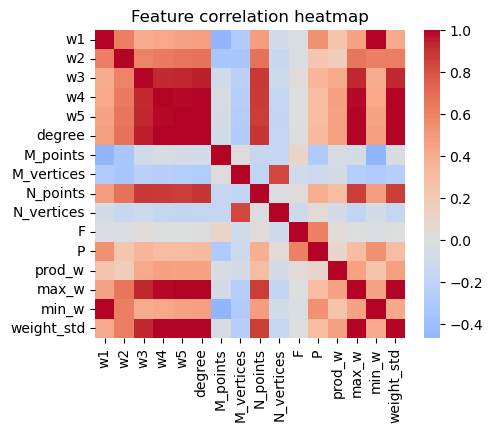

In [267]:
# Correlation heatmap 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(file.corr(), cmap="coolwarm", center=0)
plt.title("Feature correlation heatmap")
plt.show()


Linear R2: [0.97977264 0.98325198 0.97908617]
GBR χ R²: 0.9882094784727724


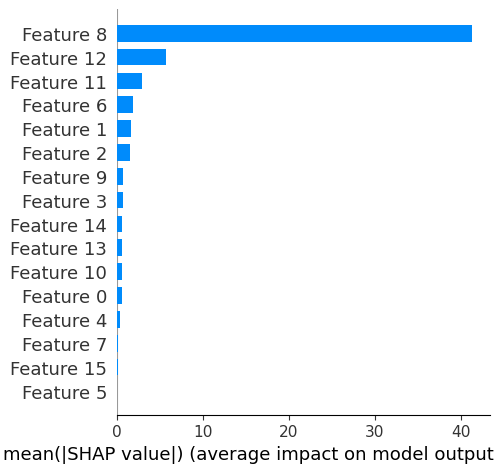

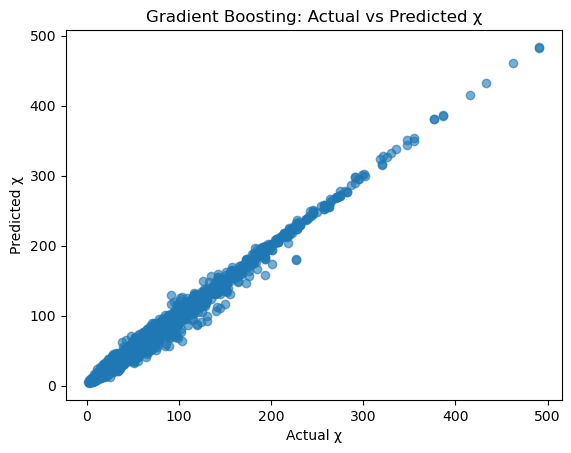

In [268]:
#Geometry based regression 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error


X = file[["w1", "w2", "w3", "w4", "w5", "degree", "M_points", "M_vertices",
            "N_points" ,"N_vertices","F","P","prod_w","max_w","min_w","weight_std"]]
y = file2[["h11","h21","chi"]]  
X = X.fillna(0)
X_n = X.to_numpy()
Y_n = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_n, Y_n, test_size=0.3, random_state=60)

# Linear regression
lin = LinearRegression().fit(X_train, y_train)
y_pred_lin = lin.predict(X_test)
print("Linear R2:", r2_score(y_test, y_pred_lin, multioutput="raw_values"))
# Gradient Boosting 
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05)
gbr.fit(X_train, y_train[:,0])  # example single target
y_pred_gbr = gbr.predict(X_test)
print("GBR χ R²:", r2_score(y_test[:,0], y_pred_gbr))
# Feature importance & SHAP
import shap

explainer = shap.Explainer(gbr)
shap_values = explainer(X_test)
#shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.gcf().set_size_inches(4.5, 4.5)
plt.show()

# Predicted vs actual plot 
plt.scatter(y_test[:,0], y_pred_gbr, alpha=0.6)
plt.xlabel("Actual χ")
plt.ylabel("Predicted χ")
plt.title("Gradient Boosting: Actual vs Predicted χ")
plt.show()
#shap.dependence_plot(8, shap_values.values, X_test)



In [269]:
#Inverse geometric analysis- guessing possible weight vector candidates (random generation approach)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.linalg import norm

# Training the regression models 
rf_h11 = RandomForestRegressor(n_estimators=200, random_state=42)
rf_h21 = RandomForestRegressor(n_estimators=200, random_state=42)
rf_chi = RandomForestRegressor(n_estimators=200, random_state=42)

rf_h11.fit(X_train, y_train[:, 0])
rf_h21.fit(X_train, y_train[:, 1])
rf_chi.fit(X_train, y_train[:, 2])

# Defining targets for the inverse design 
target_h11 = 30
target_h21 = 20
target_chi = 20

# Function for generating new candidates
def sample_candidate():
    w = np.random.randint(1, 21, size=5)
    degree = np.sum(w)
    M_points = np.random.randint(0, 100)
    M_vertices = np.random.randint(0, 50)
    N_points = np.random.randint(0, 100)
    N_vertices = np.random.randint(0, 50)
    F = np.prod(w) % 50
    P = np.max(w) - np.min(w)
    prod_w = np.prod(w)
    max_w = np.max(w)
    min_w = np.min(w)
    weight_std = np.std(w)
    
    candidate = np.array([*w, degree, M_points, M_vertices,
                          N_points, N_vertices, F, P, prod_w, max_w, min_w, weight_std])
    
    return candidate

# Checking reflexivity (approximate)
def is_reflexive(weights, degree):
    return all(w <= degree/2 for w in weights)


# Checking transversality (approx)
def is_quasismooth(weights, degree):
    # Checking if each weight divides the degree
    return all(degree % w == 0 for w in weights)

# Checking physical constraint 
def check_physical_constraints(weights, degree):
    return is_reflexive(weights,degree) and is_quasismooth(weights, degree)

# Generating candidates and predicting invariants 
n_candidates = 10000
valid_candidates = []
pred_h11 = []
pred_h21 = []
pred_chi = []

for _ in range(n_candidates):
    vec = sample_candidate()
    w = vec[:5]
    if check_physical_constraints(w, degree):
        valid_candidates.append(vec)
        pred_h11.append(rf_h11.predict([vec])[0])
        pred_h21.append(rf_h21.predict([vec])[0])
        pred_chi.append(rf_chi.predict([vec])[0])

valid_candidates = np.array(valid_candidates)
pred_h11 = np.array(pred_h11)
pred_h21 = np.array(pred_h21)
pred_chi = np.array(pred_chi)

# Computing fitness to target
fitness = np.abs(pred_h11 - target_h11) + np.abs(pred_h21 - target_h21) + np.abs(pred_chi - target_chi)

# Selecting top candidates
top_idx = np.argsort(fitness)[:10]
top_candidates = valid_candidates[top_idx]
top_preds = np.vstack([pred_h11[top_idx], pred_h21[top_idx], pred_chi[top_idx]]).T

# Printing output
print("Top candidate weight vectors and predicted invariants:")
for vec, pred in zip(top_candidates, top_preds):
    print(f"Weights: {vec[:5]}, degree: {vec[5]}, predicted h11: {pred[0]:.1f}, h21: {pred[1]:.1f}, chi: {pred[2]:.1f}")

Top candidate weight vectors and predicted invariants:
Weights: [ 6.  7. 14.  1.  3.], degree: 31.0, predicted h11: 27.2, h21: 6.8, chi: 24.6
Weights: [14.  7.  7. 14.  7.], degree: 49.0, predicted h11: 18.1, h21: 12.6, chi: 0.7
Weights: [3. 6. 2. 3. 6.], degree: 20.0, predicted h11: 38.3, h21: 9.1, chi: 42.4
Weights: [6. 2. 2. 7. 7.], degree: 24.0, predicted h11: 52.6, h21: 22.8, chi: 43.5
Weights: [1. 6. 2. 2. 2.], degree: 13.0, predicted h11: 57.0, h21: 40.5, chi: 22.7
Weights: [14.  7.  1. 14.  2.], degree: 38.0, predicted h11: 65.8, h21: 50.8, chi: 16.1
Weights: [ 6.  2. 14.  1.  2.], degree: 25.0, predicted h11: 57.1, h21: 53.1, chi: 8.6
Weights: [ 3.  3.  2.  3. 14.], degree: 25.0, predicted h11: 62.4, h21: 51.7, chi: 11.1
Weights: [14.  3.  1.  3. 14.], degree: 35.0, predicted h11: 60.0, h21: 5.0, chi: 53.6
Weights: [7. 7. 3. 7. 1.], degree: 25.0, predicted h11: 70.0, h21: 55.9, chi: 0.9


In [270]:
#Checking if generated candidates are already in original data

# Original dataset weights
original_weights = X_n[:, :5]
# Extracting only weights
ml_weights = top_candidates[:, :5]  # shape (n_candidates, 5)

for vec in ml_weights:
    if any(np.allclose(vec, row) for row in original_weights):
        print(f"Candidate {vec} already exists in original data.")
    else:
        print(f"Candidate {vec} is new (not in original data).")

Candidate [ 6.  7. 14.  1.  3.] is new (not in original data).
Candidate [14.  7.  7. 14.  7.] is new (not in original data).
Candidate [3. 6. 2. 3. 6.] is new (not in original data).
Candidate [6. 2. 2. 7. 7.] is new (not in original data).
Candidate [1. 6. 2. 2. 2.] is new (not in original data).
Candidate [14.  7.  1. 14.  2.] is new (not in original data).
Candidate [ 6.  2. 14.  1.  2.] is new (not in original data).
Candidate [ 3.  3.  2.  3. 14.] is new (not in original data).
Candidate [14.  3.  1.  3. 14.] is new (not in original data).
Candidate [7. 7. 3. 7. 1.] is new (not in original data).


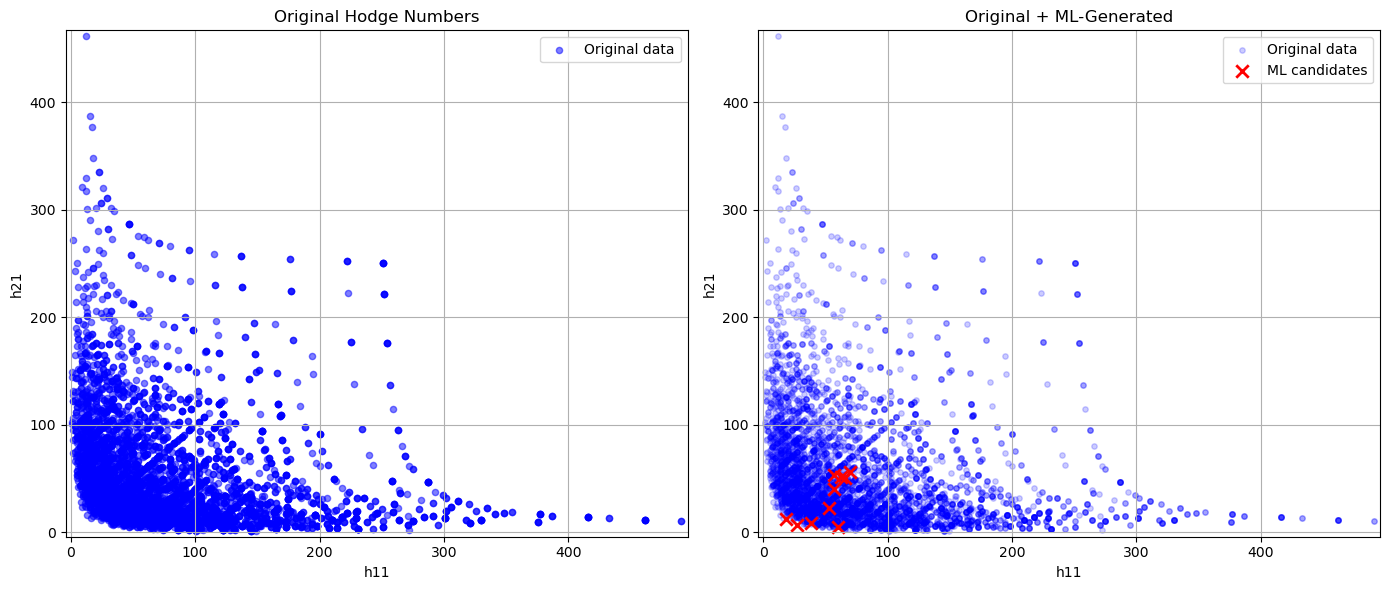

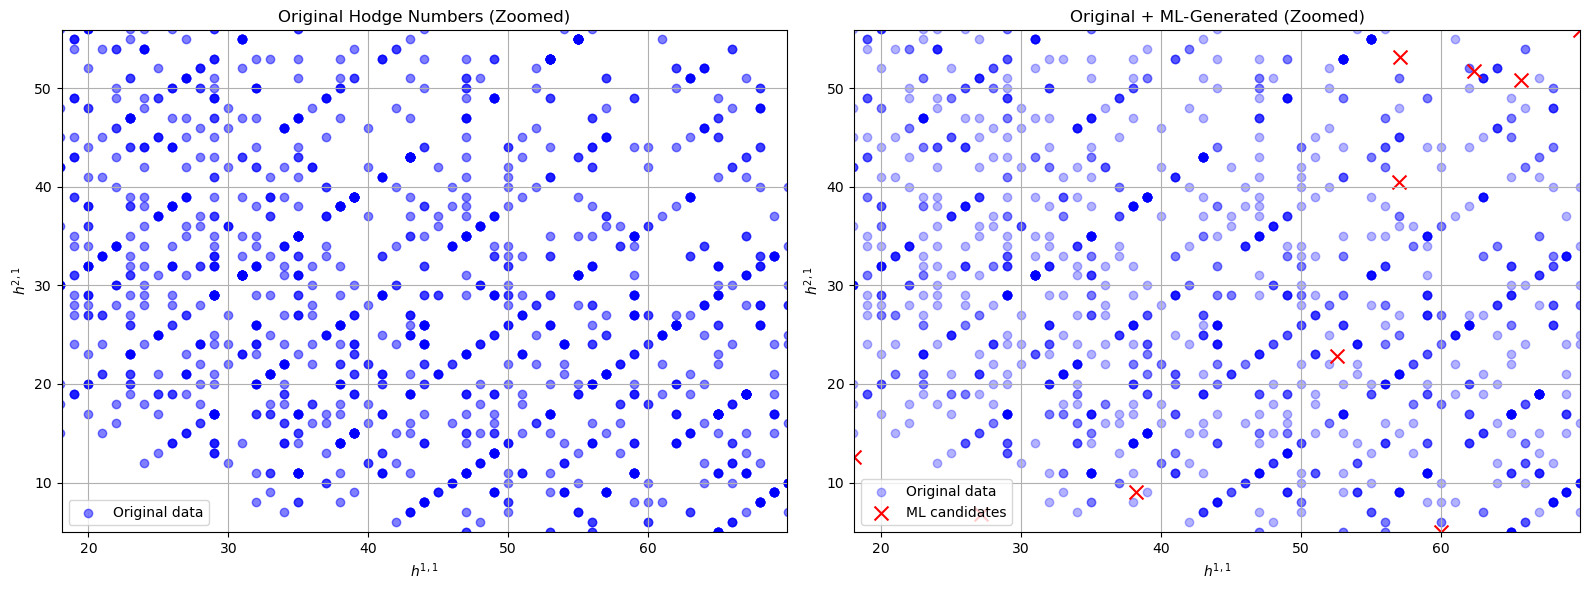

In [271]:
import matplotlib.pyplot as plt
import numpy as np

#Original data Hodge numbers
h11_orig = y_train[:, 0]
h21_orig = y_train[:, 1]

#ML-generated candidates
try:
    pred_h11_ml = np.array(top_preds[:, 0])
    pred_h21_ml = np.array(top_preds[:, 1])
except NameError:
    print("Error")
    pred_h11_ml = np.array([])
    pred_h21_ml = np.array([])

#Whole scale plots

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original dataset
axes[0].scatter(h11_orig, h21_orig, color='blue', alpha=0.5, s=20, label='Original data')
axes[0].set_xlabel('h11')
axes[0].set_ylabel('h21')
axes[0].set_title('Original Hodge Numbers')
axes[0].legend()
axes[0].grid(True)

# Original + ML-generated
axes[1].scatter(h11_orig, h21_orig, color='blue', alpha=0.2, s=15, label='Original data')
axes[1].scatter(pred_h11_ml, pred_h21_ml, color='red', marker='x', s=80, linewidths=2, label='ML candidates')
axes[1].set_xlabel('h11')
axes[1].set_ylabel('h21')
axes[1].set_title('Original + ML-Generated')
axes[1].legend()
axes[1].grid(True)

# Matching axis limits for consistent scale
if len(pred_h11_ml) > 0:
    all_h11 = np.concatenate([h11_orig, pred_h11_ml])
    all_h21 = np.concatenate([h21_orig, pred_h21_ml])
    xmin, xmax = np.min(all_h11) - 5, np.max(all_h11) + 5
    ymin, ymax = np.min(all_h21) - 5, np.max(all_h21) + 5
    for ax in axes:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

#Zoomed plots

x_range = np.max(pred_h11_ml) - np.min(pred_h11_ml)
y_range = np.max(pred_h21_ml) - np.min(pred_h21_ml)

pad_x = 0.0 * x_range   # can increase (decrease) 0.0 to zoom out (in)
pad_y = 0.0 * y_range


if len(pred_h11_ml) > 0:
    x_min, x_max = np.min(pred_h11_ml) - pad_x, np.max(pred_h11_ml) + pad_x
    y_min, y_max = np.min(pred_h21_ml) - pad_y, np.max(pred_h21_ml) + pad_y

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Original (zoomed)
    axes[0].scatter(h11_orig, h21_orig, color='blue', alpha=0.5, label='Original data')
    axes[0].set_xlim(x_min, x_max)
    axes[0].set_ylim(y_min, y_max)
    axes[0].set_xlabel('$h^{1,1}$')
    axes[0].set_ylabel('$h^{2,1}$')
    axes[0].set_title('Original Hodge Numbers (Zoomed)')
    axes[0].legend()
    axes[0].grid(True)

    # Original + ML-generated (zoomed)
    axes[1].scatter(h11_orig, h21_orig, color='blue', alpha=0.3, label='Original data')
    axes[1].scatter(pred_h11_ml, pred_h21_ml, color='red', marker='x', s=100, label='ML candidates')
    axes[1].set_xlim(x_min, x_max)
    axes[1].set_ylim(y_min, y_max)
    axes[1].set_xlabel('$h^{1,1}$')
    axes[1].set_ylabel('$h^{2,1}$')
    axes[1].set_title('Original + ML-Generated (Zoomed)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Fail")


In [272]:
#Inverse geometric analysis- guessing possible weight vector candidates (perturbation generation approach)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from math import gcd

# Training Random Forest regressors 
rf_h11 = RandomForestRegressor(n_estimators=200, random_state=42)
rf_h21 = RandomForestRegressor(n_estimators=200, random_state=42)
rf_chi = RandomForestRegressor(n_estimators=200, random_state=42)

rf_h11.fit(X_train, y_train[:,0])
rf_h21.fit(X_train, y_train[:,1])
rf_chi.fit(X_train, y_train[:,2])

# Approximating physical constraints
def is_quasismooth(weights, degree):
    # Count how many weights divide the degree
    divisible_count = sum(degree % w == 0 for w in weights)
    # Require at least 3 weights to divide the degree (relaxed criterion)
    if divisible_count < 3:
        return False
    
    # Checking GCD of weight pairs > 1 to reduce obvious singularities
    for i in range(len(weights)):
        for j in range(i+1, len(weights)):
            if gcd(int(weights[i]), int(weights[j])) > 1 and degree % gcd(int(weights[i]), int(weights[j])) != 0:
                return False
    return True
    
def is_reflexive(weights, degree):
    return all(w <= degree / 2 for w in weights)

def check_physical_constraints(weights, degree):
    return is_quasismooth(weights, degree) and is_reflexive(weights, degree)

# Candidate generation: perturbation near dataset entries 
def sample_near_dataset(X_array, perturb=2):
    # Picking a random row from dataset
    row = X_array[np.random.randint(0, len(X_array))]
    # Perturbing the first 5 weights
    w = row[:5] + np.random.randint(-perturb, perturb+1, size=5)
    w = np.clip(w, 1, 20)  # keep weights positive and within dataset-like range
    degree = np.sum(w)
    
    # Randomising other features
    M_points = np.random.randint(0, 100)
    M_vertices = np.random.randint(0, 50)
    N_points = np.random.randint(0, 100)
    N_vertices = np.random.randint(0, 50)
    F = np.prod(w) % 50
    P = np.max(w) - np.min(w)
    prod_w = np.prod(w)
    max_w_val = np.max(w)
    min_w_val = np.min(w)
    weight_std = np.std(w)

    candidate = np.array([*w, degree, M_points, M_vertices,
                          N_points, N_vertices, F, P, prod_w, max_w_val, min_w_val, weight_std])
    return candidate

# Inverse design target 
target_h11 = 30
target_h21 = 20
target_chi = 2*(target_h11 - target_h21)

# Generating candidates 
n_candidates = 10000
valid_candidates = []
pred_h11, pred_h21, pred_chi = [], [], []

for _ in range(n_candidates):
    vec = sample_near_dataset(X_n, perturb=2)
    w = vec[:5]
    degree = vec[5]

    if check_physical_constraints(w, degree):
        # Predict invariants
        h11_pred = rf_h11.predict([vec])[0]
        h21_pred = rf_h21.predict([vec])[0]
        chi_pred = 2*(h11_pred - h21_pred)  # enforce CY 3-fold chi consistency
        
        valid_candidates.append(vec)
        pred_h11.append(h11_pred)
        pred_h21.append(h21_pred)
        pred_chi.append(chi_pred)

# Converting to arrays
valid_candidates = np.array(valid_candidates)
pred_h11 = np.array(pred_h11)
pred_h21 = np.array(pred_h21)
pred_chi = np.array(pred_chi)

# Computing fitness to target
fitness = np.abs(pred_h11 - target_h11) + np.abs(pred_h21 - target_h21) + np.abs(pred_chi - target_chi)

# Selecting the top 10 candidates 
top_idx = np.argsort(fitness)[:10]
top_candidates = valid_candidates[top_idx]
top_preds = np.vstack([pred_h11[top_idx], pred_h21[top_idx], pred_chi[top_idx]]).T
# Filtering top candidates (avoiding repititions)
filtered_candidates = []
filtered_preds = []

for vec, pred in zip(top_candidates, top_preds):
    weights = vec[:5]
    # Compute standard deviation of weights
    std_w = np.std(weights)
    # Keeping candidates with some diversity (std > 2) and not all weights at max
    if std_w > 2 and not np.all(weights == 20):
        filtered_candidates.append(vec)
        filtered_preds.append(pred)

filtered_candidates = np.array(filtered_candidates)
filtered_preds = np.array(filtered_preds)

# Printing filtered results 
print("Physically plausible top candidates:")
for vec, pred in zip(filtered_candidates, filtered_preds):
    print(f"Weights: {vec[:5]}, degree: {vec[5]}, predicted h11: {pred[0]:.1f}, h21: {pred[1]:.1f}, chi: {pred[2]:.1f}")


Physically plausible top candidates:
Weights: [ 6. 14. 20. 20. 20.], degree: 80.0, predicted h11: 30.5, h21: 19.9, chi: 21.1
Weights: [ 4. 16. 20. 20. 20.], degree: 80.0, predicted h11: 30.4, h21: 19.4, chi: 22.0


In [273]:
# Checking if generated candidates are already in original data
original_weights_set = set(tuple(map(float, row[:5])) for row in X_n)

final_candidates = []
final_preds = []

for vec, pred in zip(filtered_candidates, filtered_preds):
    w_tuple = tuple(map(float, vec[:5]))
    if w_tuple not in original_weights_set:
        final_candidates.append(vec)
        final_preds.append(pred)

print("Do candidates already exist in original dataset?")
for vec in final_candidates:
    w_tuple = tuple(map(float, vec[:5]))
    if w_tuple in original_weights_set:
        print(f"Candidate {w_tuple} already exists in original data.")
    else:
        print(f"Candidate {w_tuple} is new (not in original data).")
final_candidates = np.array(final_candidates)
final_preds = np.array(final_preds)

Do candidates already exist in original dataset?
Candidate (6.0, 14.0, 20.0, 20.0, 20.0) is new (not in original data).
Candidate (4.0, 16.0, 20.0, 20.0, 20.0) is new (not in original data).


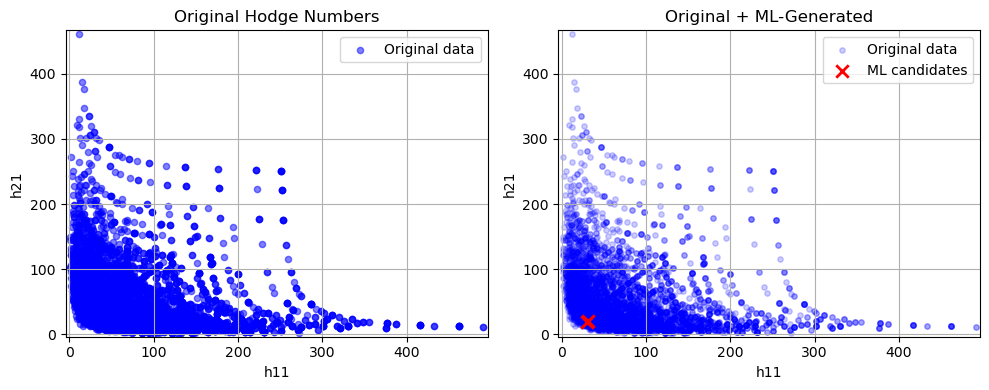

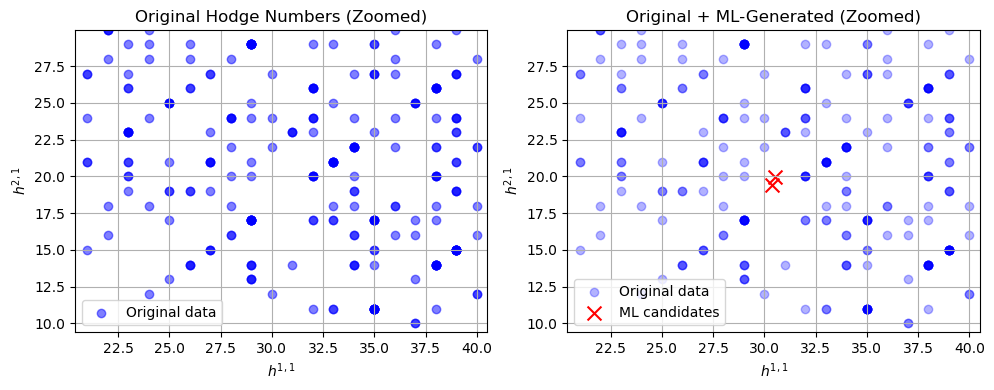

In [274]:
import matplotlib.pyplot as plt
import numpy as np

# Original data
h11_orig = y_train[:, 0]
h21_orig = y_train[:, 1]

# New ML-generated candidates 
top_new_h11=np.array(final_preds[:,0])
top_new_h21=np.array(final_preds[:,1])

#Whole scale plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Left: Original data (full)
axes[0].scatter(h11_orig, h21_orig, color='blue', alpha=0.5, s=20, label='Original data')
axes[0].set_xlabel('h11')
axes[0].set_ylabel('h21')
axes[0].set_title('Original Hodge Numbers')
axes[0].legend()
axes[0].grid(True)

# Right: Original + ML candidates (full)
axes[1].scatter(h11_orig, h21_orig, color='blue', alpha=0.2, s=15, label='Original data')
axes[1].scatter(top_new_h11, top_new_h21, color='red',
                   marker='x', s=80, linewidths=2, label='ML candidates')
axes[1].set_xlabel('h11')
axes[1].set_ylabel('h21')
axes[1].set_title('Original + ML-Generated')
axes[1].legend()
axes[1].grid(True)

# Matching axis limits for consistent scale
if len(top_new_h11) > 0:
    all_h11 = np.concatenate([h11_orig, top_new_h11])
    all_h21 = np.concatenate([h21_orig, top_new_h21])
    xmin, xmax = np.min(all_h11) - 5, np.max(all_h11) + 5
    ymin, ymax = np.min(all_h21) - 5, np.max(all_h21) + 5
    for ax in axes:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

if len(top_new_h11) > 0:
    padding = 10 
    x_min, x_max = np.min(top_new_h11) - padding, np.max(top_new_h11) + padding
    y_min, y_max = np.min(top_new_h21) - padding, np.max(top_new_h21) + padding

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Original (zoomed)
    axes[0].scatter(h11_orig, h21_orig, color='blue', alpha=0.5, label='Original data')
    axes[0].set_xlim(x_min, x_max)
    axes[0].set_ylim(y_min, y_max)
    axes[0].set_xlabel('$h^{1,1}$')
    axes[0].set_ylabel('$h^{2,1}$')
    axes[0].set_title('Original Hodge Numbers (Zoomed)')
    axes[0].legend()
    axes[0].grid(True)

    # Original + ML-generated (zoomed)
    axes[1].scatter(h11_orig, h21_orig, color='blue', alpha=0.3, label='Original data')
    axes[1].scatter(top_new_h11, top_new_h21, color='red', marker='x', s=100, label='ML candidates')
    axes[1].set_xlim(x_min, x_max)
    axes[1].set_ylim(y_min, y_max)
    axes[1].set_xlabel('$h^{1,1}$')
    axes[1].set_ylabel('$h^{2,1}$')
    axes[1].set_title('Original + ML-Generated (Zoomed)')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Fail")

Best R² on subset: 0.7678689864741812
Best parameters: {'reps': 1, 'C': 100, 'epsilon': 0.2}


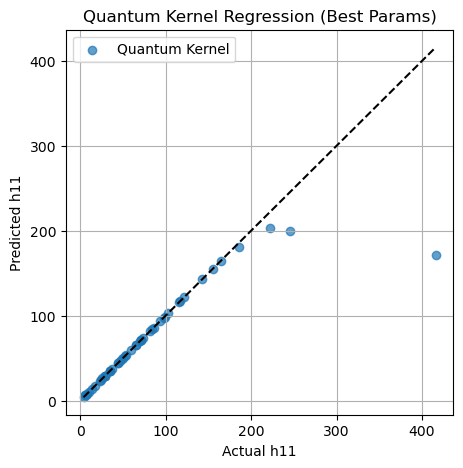

In [275]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Creating subset 
n_subset = 50
X_subset = X_train[:n_subset, :10]
y_subset = y_train[:n_subset, 0]  # h11

# Scaling features 
scaler = MinMaxScaler((-1, 1))
X_scaled = scaler.fit_transform(X_subset)

# PCA to reduce dimension 
X_pca = PCA(n_components=5).fit_transform(X_scaled)

# Hyperparameter grid 
reps_list = [1, 2, 3]          
C_list = [10, 50, 100]          
epsilon_list = [0.05, 0.1, 0.2]  # SVR epsilon

best_r2 = -np.inf
best_params = {}
best_pred = None

for reps in reps_list:
    feature_map = ZZFeatureMap(feature_dimension=X_pca.shape[1],
                               reps=reps, entanglement='full')
    qkernel = FidelityQuantumKernel(feature_map=feature_map)
    
    # Evaluate kernel on subset
    K_train = qkernel.evaluate(X_pca)
    
    for C in C_list:
        for eps in epsilon_list:
            svr_q = SVR(kernel="precomputed", C=C, epsilon=eps)
            svr_q.fit(K_train, y_subset)
            y_pred = svr_q.predict(K_train)
            r2 = r2_score(y_subset, y_pred)
            
            if r2 > best_r2:
                best_r2 = r2
                best_params = {'reps': reps, 'C': C, 'epsilon': eps}
                best_pred = y_pred

print("Best R² on subset:", best_r2)
print("Best parameters:", best_params)

# --- Plot predicted vs actual ---
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.scatter(y_subset, best_pred, label="Quantum Kernel", alpha=0.7)
plt.plot([y_subset.min(), y_subset.max()],
         [y_subset.min(), y_subset.max()], 'k--')
plt.xlabel("Actual h11")
plt.ylabel("Predicted h11")
plt.title("Quantum Kernel Regression (Best Params)")
plt.grid(True)
plt.legend()
plt.show()


Classical RBF R² on subset: 0.9174000986252914
Quantum kernel R² on subset: 0.8533769905828548


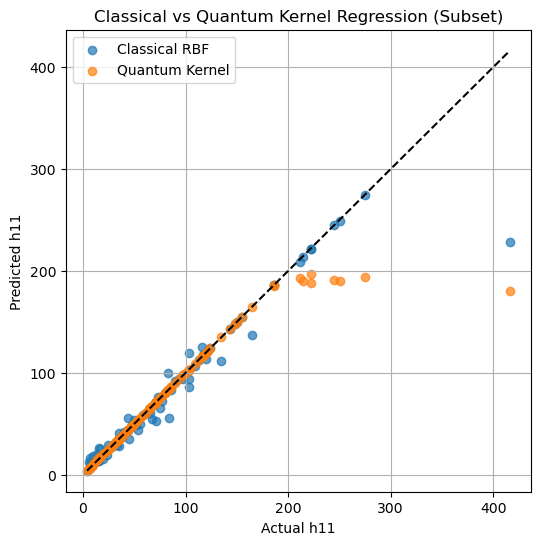

In [276]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Choosing a subset
n_subset = 100
X_subset = X_train[:n_subset, :10]   
y_subset = y_train[:n_subset, 0]     # h11

# Scaling features to [-1,1] for ZZFeatureMap
scaler = MinMaxScaler((-1, 1))
X_scaled = scaler.fit_transform(X_subset)

# Classical RBF SVR 
svr_rbf = SVR(kernel="rbf", C=100, gamma=1, epsilon=0.1)
svr_rbf.fit(X_scaled, y_subset)
y_pred_rbf = svr_rbf.predict(X_scaled)
r2_rbf = r2_score(y_subset, y_pred_rbf)
print("Classical RBF R² on subset:", r2_rbf)

# Quantum Kernel Regression (ZZFeatureMap) 
feature_map = ZZFeatureMap(feature_dimension=X_scaled.shape[1], reps=1, entanglement='full')
qkernel = FidelityQuantumKernel(feature_map=feature_map)

# Computing kernel matrices
K_train = qkernel.evaluate(X_scaled)
svr_q = SVR(kernel="precomputed", C=100, epsilon=0.1)
svr_q.fit(K_train, y_subset)
y_pred_q = svr_q.predict(K_train)
r2_q = r2_score(y_subset, y_pred_q)
print("Quantum kernel R² on subset:", r2_q)

# Plotting
plt.figure(figsize=(6,6))
plt.scatter(y_subset, y_pred_rbf, label="Classical RBF", alpha=0.7)
plt.scatter(y_subset, y_pred_q, label="Quantum Kernel", alpha=0.7)
plt.plot([y_subset.min(), y_subset.max()],
         [y_subset.min(), y_subset.max()], 'k--')
plt.xlabel("Actual h11")
plt.ylabel("Predicted h11")
plt.title("Classical vs Quantum Kernel Regression (Subset)")
plt.legend()
plt.grid(True)
plt.show()


Classical RBF R² on test subset: 0.8661071227023984
Quantum kernel R² on test subset: 0.2696905646549388


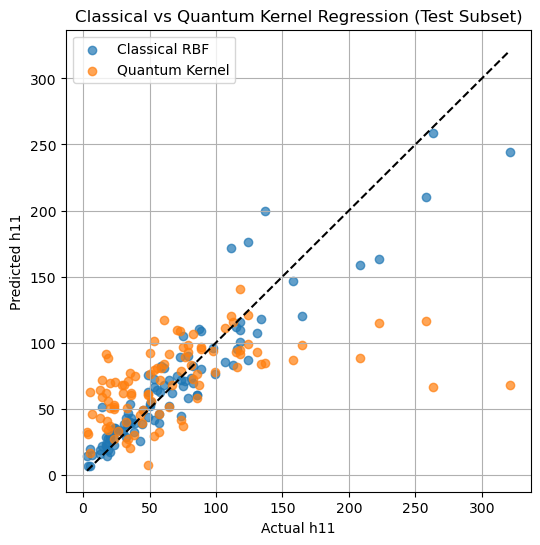

In [277]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

# Selecting subset 
n_subset = 100
cols = list(range(10))

X_train_subset = X_train[:n_subset, cols]
y_train_subset = y_train[:n_subset, 0]  # h11
X_test_subset = X_test[:n_subset, cols]
y_test_subset = y_test[:n_subset, 0]

# Scaling features to [-1,1] 
scaler = MinMaxScaler((-1, 1))
X_train_scaled = scaler.fit_transform(X_train_subset)
X_test_scaled = scaler.transform(X_test_subset)

# PCA for dimensionality reduction 
n_components = 5  
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Classical RBF SVR 
svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_rbf.fit(X_train_pca, y_train_subset)
y_pred_rbf = svr_rbf.predict(X_test_pca)
r2_rbf = r2_score(y_test_subset, y_pred_rbf)
print("Classical RBF R² on test subset:", r2_rbf)

# Quantum Kernel Regression  
feature_map = PauliFeatureMap(feature_dimension=X_train_pca.shape[1],
                           reps=1, entanglement='full')
qkernel = FidelityQuantumKernel(feature_map=feature_map)

# Computing kernel matrices
K_train = qkernel.evaluate(X_train_pca)
K_test = qkernel.evaluate(X_test_pca, X_train_pca)  # test vs train

# Training SVR with precomputed quantum kernel
svr_q = SVR(kernel="precomputed", C=500, epsilon=0.2)
svr_q.fit(K_train, y_train_subset)
y_pred_q = svr_q.predict(K_test)
r2_q = r2_score(y_test_subset, y_pred_q)
print("Quantum kernel R² on test subset:", r2_q)

# Plotting 
plt.figure(figsize=(6,6))
plt.scatter(y_test_subset, y_pred_rbf, label="Classical RBF", alpha=0.7)
plt.scatter(y_test_subset, y_pred_q, label="Quantum Kernel", alpha=0.7)
plt.plot([y_test_subset.min(), y_test_subset.max()],
         [y_test_subset.min(), y_test_subset.max()], 'k--')
plt.xlabel("Actual h11")
plt.ylabel("Predicted h11")
plt.title("Classical vs Quantum Kernel Regression (Test Subset)")
plt.legend()
plt.grid(True)
plt.show()
